<h1> Проект 5.10.1.

<h1>Кейс №1 - Приложение знакомств</h1>

Вы работаете аналитиком в приложении для онлайн-знакомств. <br>
Механика приложения следующая: пользователи видят в приложении анкеты друг друга и <br>
могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – <br>
это называется мэтч, и у пользователей появляется возможность познакомиться.<br>

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. <br>
Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. <br>
<i><b>Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. <br>
Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.</i></b>

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. <br>
Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и <br>
статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. <br>
Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, <br>
стоит ли включать новую систему поиска анкет на всех пользователей.

<b>NB! Не стоит использовать интерактивные графики в итоговом файле – <br>
они имеют смысл только в динамических отчётах вроде веб-страницы.</b>

В поле ответа прикрепите файл формата .ipynb — то есть обычный Jupyter Notebook <br>
со всеми вашими действиями, результатами, графиками и выводами.

### БИБЛИОТЕКИ

In [2]:
# Подключим библиотеку pandas и назовем её pd
import pandas as pd
# Подключим библиотеку numpy и назовем её np
import numpy as np
# Подключим библиотеку scipy, и возьмем оттуда модуль со stats (статистические распределения и функции)
from scipy import stats as ss
from scipy.stats import bootstrap as bs
import pingouin as pg

# Импорт библиотек проводника
import os

# Подключим библиотеку seaborn и назовем её sns
import seaborn as sns
# Подключим библиотеку matplotlib и назовем её plt
import matplotlib.pyplot as plt
# Разрешим строить графики в интерактивном режиме
%matplotlib inline

### ЗАГРУЗКА ДАННЫХ

In [3]:
# Чтобы узнать текущую дирректорию
os.getcwd()
# Чтобы узнать что лежит в текущей дирректории
os.listdir()
# - ~/ - относительный путь
# - ../ - путь с поднятием вверх из другой папки до корневой
# (подъём на уровень выше - домашняя директория ~)

# Запишем путь файла в переменную
path_df_meeting = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-mihalev/Statistic-Python_Lessions/Lecture_10/dating_data.csv"
# Cчитаем DF c помощью лямбда-функции
download_df_meeting = lambda x:  pd.read_csv(x, sep=',') # , dtype={'Year': 'int'}
# Присвоим переменную датафрейму
df_meeting = download_df_meeting(path_df_meeting)
df_meeting

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


### ПРОВЕРКА ДАННЫХ

In [4]:
# Проверим размер DF
print("Размер таблицы взаимодействия пользователей:\n{}".format(df_meeting.shape), "\n")

# Проверим типы данных столбцов DF
print("Форматы колонок таблицы взаимодействия пользователей:\n{}".format(df_meeting.dtypes), '\n')

# Проверим DF на пропуски
print("Число пропусков в колонках таблицы взаимодействия пользователей:\n{}".format(df_meeting.isna().sum()), '\n')

Размер таблицы взаимодействия пользователей:
(14514, 4) 

Форматы колонок таблицы взаимодействия пользователей:
user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object 

Число пропусков в колонках таблицы взаимодействия пользователей:
user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64 



### РАЗБИВКА DF НА 2 ГРУППЫ

In [24]:
#  1 группа (контрольная)
df_meeting_control = df_meeting.query("group == 0")

#  2 группа (тестовая)
df_meeting_test = df_meeting.query("group == 1")

print("Размер 1 группы (контрольной): {} пар".format(df_meeting_control.shape[0]))
print("Размер 2 группы (тестовой):    {} пар".format(df_meeting_test.shape[0]), '\n')

print(f'Колличество матчей в контольной группе =  {df_meeting_control.sum()} штук')
print(f'Колличество матчей в тестовой группе   = {df_meeting_test.sum()} штук\n')

Размер 1 группы (контрольной): 4792 пар
Размер 2 группы (тестовой):    9722 пар 

Колличество матчей в контольной группе =  user_id_1    2352483
user_id_2    2390733
group              0
is_match         934
dtype: int64 штук
Колличество матчей в тестовой группе   = user_id_1    4907712
user_id_2    4893027
group           9722
is_match        3909
dtype: int64 штук



<h3>Какие метрики отвечают за качество сервиса?</h3><br>
<blockquote> Так как AB-тест должен ответить на вопрос: 
    <blockquote><b>"Лучше ли работает новый алгорим поиска <b>подходящих анкет?"</b></blockquote>
Показатель <i>улучшения качества сервиса:</i>
        <ol>
            <li><b>Кол-во матчей на пользователя user_id_1 () </b> в тестовой группе <br>
            по сравнению с контрольной группой!</li>
            <li><b>Кол-во матчей на пользователя user_id_1 () к показам </b> в тестовой группе <br>
            по сравнению с контрольной группой!</li>
        </ol>
</blockquote>

<h3>1) Проверка метрики: <i>кол-во матчей на пользователя user_id_1 - MPU</i> </h3>

In [88]:
# Определим метрику

df_meeting_MPU = df_meeting\
                        .groupby(["user_id_1", 'group'], as_index=False)\
                        .agg({"is_match":'sum'})\
                        .sort_values(["user_id_1", "group"])\
                        .rename(columns={"is_match":"MPU"})

# Поделим на группы
# И определим MPU в рамках каждой группы на уникального пользователя
# Определим среднее значение MPU на уникального пользователя в группе

#  1 группа (контрольная)
df_meeting_MPU_control = df_meeting_MPU.query("group == 0")

# ---------------------------------------------------------------------------------------------

#  2 группа (тестовая)
df_meeting_MPU_test = df_meeting_MPU.query("group == 1")


print("Размер выборки MPU контрольной группы: {}".format(df_meeting_MPU_control.shape[0]))
print("Размер выборки MPU тестовой группы:    {}".format(df_meeting_MPU_test.shape[0]))

Размер выборки MPU контрольной группы: 501
Размер выборки MPU тестовой группы:    499


In [89]:
# Посчитаем ср.значения MPU в 2 группах
MPU_mean_control = df_meeting_MPU_control.MPU.mean()
MPU_mean_test = df_meeting_MPU_test.MPU.mean()
print("Среднее значение MPU в контрольной группе - {0}".format(MPU_mean_control))
print("Среднее значение MPU в тестовой группе - {0}".format(MPU_mean_test))

Среднее значение MPU в контрольной группе - 1.8642714570858283
Среднее значение MPU в тестовой группе - 7.833667334669339


<H3>CТАТИСТИЧЕСКИ СРАВНИМ СРЕДНИЕ ПОКАЗАТЕЛИ MPU <BR>В ГРУППАХ С ПОМОЩЬЮ T-ТЕСТА<br></H3>
 (так как мы имеем дело в <b>количественной</b> переменной)</H4>
 <blockquote>
<ul>
<li>Нулевая гипотеза: ср.значения стат.значимо НЕ отличаются (p-value > 0.05)!</li>
<li>Альтернативная гипотеза: ср.значения стат.значимо отличаются (p-value < 0.05)!</li>
</ul>
</blockquote>    

<h4> ПРОВЕРКА УСЛОВИЯ НОРМАЛЬНОСТИ Т-ТЕСТА </h4>
(тест Шапиро не используем , тк размеры выборок большие - n>30)

In [90]:
# Проверка через normaltest - контрольной группы
print(f"Контрольная группа - {ss.normaltest(df_meeting_MPU_control.MPU)}")

# Проверка через normaltest - тестовой группы
print(f"Тестовая группа    - {ss.normaltest(df_meeting_MPU_test.MPU)}","\n")

# Проверка через normaltest pingouin - обеих групп
print(pg.normality(data=df_meeting_MPU, dv="MPU", group='group', method='normaltest'))

Контрольная группа - NormaltestResult(statistic=62.41476656929049, pvalue=2.79772900172115e-14)
Тестовая группа    - NormaltestResult(statistic=2.353675608026829, pvalue=0.30825195213008727) 

           W          pval  normal
1   2.353676  3.082520e-01    True
0  62.414767  2.797729e-14   False


<h5>
Распределение MPU контрольной группы - не нормальное<br>
Распределение MPU тестовой группы       -      нормальное
</h5>

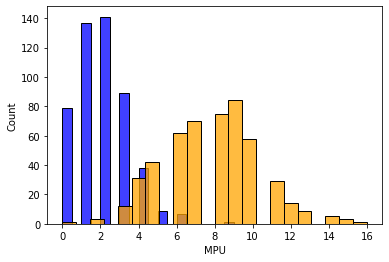

In [91]:
sns.histplot(data=df_meeting_MPU_control.MPU, color='blue')
sns.histplot(data=df_meeting_MPU_test.MPU, color='orange')

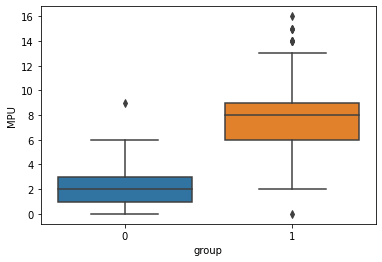

In [92]:
sns.boxplot(data=df_meeting_MPU,y='MPU',x='group')

<h4> ПРОВЕРКА УСЛОВИЯ ГОМОГЕННОСТИ ДИСПЕРСИЙ РАСПРЕДЕЛЕНИЙ </h4><br>
<blockquote>    
<ul>
<li>Нулевая гипотеза - дисперсии равны</li>
<li>Альтернативная гипотеза - дисперсии НЕ равны</li>
    </ul></blockquote>    

In [93]:
# Проверка через критерий Левена
ss.levene(df_meeting_MPU_control.MPU, df_meeting_MPU_test.MPU)

LeveneResult(statistic=134.17424158182058, pvalue=3.3545479435181664e-29)

In [94]:
# Проверка через критерий Левена - pingouin
pg.homoscedasticity(data=df_meeting_MPU, dv="MPU", group='group')

,W,pval,equal_var
levene,134.174242,3.354548e-29,False


<h5>Поскольку p-value < 0.05, то имеет смысл отклонить нулевую гипотезу<br>
и принять, что дисперсии распределений НЕ гомогенны!!!
</h5>

<h4>ПРОИЗВЕДЕМ T-ТЕСТ<br>
    (справледливости ради, его не стоит делать, тк условия не выполнены)</h4><br>
В целом, Т-тест с определенной точностью может<br>
"переварить" и не совсем нормальные распределения. Попробуем.


In [95]:
SSttest = ss.ttest_ind(df_meeting_MPU_control.MPU, df_meeting_MPU_test.MPU)
SSttest

Ttest_indResult(statistic=-47.180514076216454, pvalue=2.2880416014858935e-256)

In [96]:
# с помощью pingouin
PGttest = pg.ttest(df_meeting_MPU_control.MPU, df_meeting_MPU_test.MPU)
PGttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-47.129786,772.18908,two-sided,2.129646e-229,"[-6.22, -5.72]",2.983964,4.329e+251,1.0


<h5>
Так как p-value < 0.05, то отклоняем нулевую гипотезу,
и делаем вывод - </h5>
    <br>Средние значения MPU в группах стат.значимо отличаются!<br>
    И в тестовой группе качество сервиса стат.значимо выросло (улучшилось).


<h4>ПРОИЗВЕДЕМ ПАРАМЕТРИЧЕСКИЙ КРИТЕРИЙ МАННА-УИТНИ</h4><br>
(Так как критерий для обычного Т-теста не выполнены и он может ошибаться)

In [97]:
ss.mannwhitneyu(df_meeting_MPU_control.MPU, df_meeting_MPU_test.MPU)

MannwhitneyuResult(statistic=4406.0, pvalue=3.964683653930119e-155)

<h5>
Так как p-value < 0.05, то отклоняем нулевую гипотезу,
и делаем вывод - </h5>
    <br>Средние значения MPU в группах стат.значимо отличаются!<br>
    И в тестовой группе качество сервиса стат.значимо выросло (улучшилось).

<h4>ПРОИЗВЕДЕМ МЕТОД BOOTSTRAP</h4><br>
(По сути, этот метод и должен применяться для ставнения средний значений 2-ух групп<br>
при условии, ненормальности распределений и неоднородности их дисперсий)<br>
Можно сравнить как средние величины так и медианы.

In [98]:
# Cравним средние
bs_MPU_control = bs((df_meeting_MPU_control.MPU, ), np.mean)
bs_MPU_control

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.748502994011976, high=1.9820359281437125), standard_error=0.06010790773417709)

In [99]:
bs_MPU_test = bs((df_meeting_MPU_test.MPU, ), np.mean)
bs_MPU_test

BootstrapResult(confidence_interval=ConfidenceInterval(low=7.615230460921843, high=8.050100200400802), standard_error=0.1109722781576418)

<h5>
Исходя из наложения доверительных интервалов средних значений, видно что им явно далеко до пересечения,<br>
отклоняем нулевую гипотезу, а изменения признаём статзначимыми в положительную сторону (MPU значимо вырос)
</h5>


<h3>2) Проверка метрики: <i>кол-во матчей на пользователя user_id_1 к показам - MPUS</i></h3>

In [100]:
# Определим метрику

df_meeting_MPU = df_meeting\
                        .groupby(["user_id_1", 'group'], as_index=False)\
                        .agg({"is_match":'sum'})\
                        .sort_values(["user_id_1", "group"])\
                        .rename(columns={"is_match":"MPU"})

# Поделим на группы
# И определим MPU в рамках каждой группы на уникального пользователя
# Определим среднее значение MPU на уникального пользователя в группе

#  1 группа (контрольная)
df_meeting_MPU_control = df_meeting_MPU.query("group == 0")

# ---------------------------------------------------------------------------------------------

#  2 группа (тестовая)
df_meeting_MPU_test = df_meeting_MPU.query("group == 1")


print("Размер выборки MPU контрольной группы: {}".format(df_meeting_MPU_control.shape[0]))
print("Размер выборки MPU тестовой группы:    {}".format(df_meeting_MPU_test.shape[0]))

Размер выборки MPU контрольной группы: 501
Размер выборки MPU тестовой группы:    499


In [101]:
df_meeting

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [102]:
# Узнаем колличество эвентов
df_meeting_events = df_meeting\
                        .groupby(["user_id_1", 'group'], as_index=False)\
                        .agg({"is_match":'count'})\
                        .sort_values(["user_id_1", "group"])\
                        .rename(columns={"is_match":"events"})

# А теперь посчитаем метриму MPUS
df_meeting_MPUS = df_meeting_MPU.merge(df_meeting_events, how="left", on=['user_id_1', 'group'])
df_meeting_MPUS['MPUS'] = df_meeting_MPUS.MPU / df_meeting_MPUS.events
df_meeting_MPUS

,user_id_1,group,MPU,events,MPUS
0,1,1,11,24,0.458333
1,2,1,7,16,0.437500
2,3,1,5,16,0.312500
3,4,0,2,9,0.222222
4,5,1,13,22,0.590909
...,...,...,...,...,...
995,996,0,1,8,0.125000
996,997,0,1,12,0.083333
997,998,1,10,18,0.555556
998,999,0,2,7,0.285714


In [103]:
# Поделим на группы
df_meeting_MPUS_control = df_meeting_MPUS.query('group == 0')
df_meeting_MPUS_test = df_meeting_MPUS.query('group == 1')

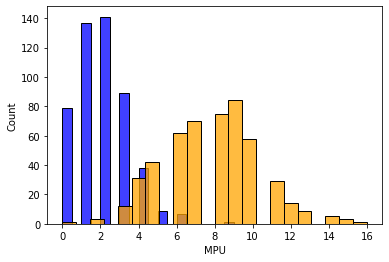

In [104]:
# Посмотрим на распределения
sns.histplot(data=df_meeting_MPUS_control.MPU, color='blue')
sns.histplot(data=df_meeting_MPUS_test.MPU, color='orange')

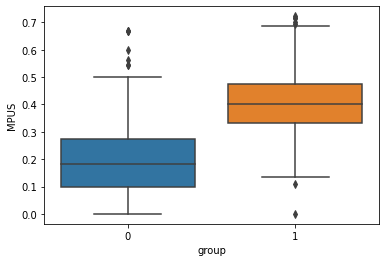

In [105]:
sns.boxplot(data=df_meeting_MPUS,y='MPUS',x='group')

<h5>В данном случае контрольная группа выглядит
    <br>более нормальной, чем приметрике MPU. Проверим.
  
</h5>

<h4> ПРОВЕРКА УСЛОВИЯ НОРМАЛЬНОСТИ Т-ТЕСТА </h4>
(тест Шапиро не используем , тк размеры выборок большие - n>30)

In [106]:
# Проверка через normaltest - контрольной группы
print(f"Контрольная группа - {ss.normaltest(df_meeting_MPUS_control.MPUS)}")

# Проверка через normaltest - тестовой группы
print(f"Тестовая группа    - {ss.normaltest(df_meeting_MPUS_test.MPUS)}","\n")

# Проверка через normaltest pingouin - обеих групп
print(pg.normality(data=df_meeting_MPUS, dv="MPUS", group='group', method='normaltest'))

Контрольная группа - NormaltestResult(statistic=24.05142184275496, pvalue=5.988252519460471e-06)
Тестовая группа    - NormaltestResult(statistic=0.27389179572110844, pvalue=0.8720174028630457) 

           W      pval  normal
1   0.273892  0.872017    True
0  24.051422  0.000006   False


<h4> Видим все то же самое, КОНТРОЛЬНАЯ ГРУППА - не нормальная!

<br>Проверим дисперсии!</h4>
<blockquote>    
<ul>
<li>Нулевая гипотеза - дисперсии равны</li>
<li>Альтернативная гипотеза - дисперсии НЕ равны</li>
    </ul></blockquote>    

In [107]:
# Проверка через критерий Левена - pingouin
pg.homoscedasticity(data=df_meeting_MPU, dv="MPU", group='group')

,W,pval,equal_var
levene,134.174242,3.354548e-29,False


#### Дисперсии также неоднородны!

<h4>ПРОИЗВЕДЕМ МЕТОД BOOTSTRAP</h4><br>
(По сути, этот метод и должен применяться для ставнения средний значений 2-ух групп<br>
при условии, ненормальности распределений и неоднородности их дисперсий)<br>
Можно сравнить как средние величины так и медианы.

In [108]:
# Cравним средние
bs_MPUS_control = bs((df_meeting_MPUS_control.MPUS, ), np.mean)
bs_MPUS_control

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.18242707703253735, high=0.20624047471550602), standard_error=0.00607446782850056)

In [109]:
bs_MPUS_test = bs((df_meeting_MPUS_test.MPUS, ), np.mean)
bs_MPUS_test

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.39223292750634636, high=0.4124034525120422), standard_error=0.00513443443916292)

<h5>
Исходя из наложения доверительных интервалов средних значений, видно что им явно далеко до пересечения,<br>
отклоняем нулевую гипотезу, а изменения признаём статзначимыми в положительную сторону (MPU значимо вырос)
</h5>

<h1>ВЫВОД:</h1>

<b>В ходе АБ-теста было получено положительное статзначимое различие между выделенными метриками.<br>
Данные метрики выросли в тестовой группе по сравнению с контрольной.<br>
Моё заключение - <i>новую систему поиска анкет стоит включать на всех пользователей!</i></b>